In [1]:
import numpy as np
import matplotlib.pyplot as plt

- All the optional weak classifiers as below:
G0_0(x) = sign(x0>-1.4), er = 0.5000
G1_0(x) = sign(x0<-1.0), er = 0.4000
G2_0(x) = sign(x0<-0.7), er = 0.3000
G3_0(x) = sign(x0<-0.3), er = 0.4000
G4_0(x) = sign(x0>0.0), er = 0.5000
G5_0(x) = sign(x0>0.3), er = 0.4000
G6_0(x) = sign(x0>0.7), er = 0.5000
G7_0(x) = sign(x0<1.0), er = 0.4000
G8_0(x) = sign(x0<1.4), er = 0.3000
G0_1(x) = sign(x1>-1.4), er = 0.5000
G1_1(x) = sign(x1<-1.0), er = 0.4000
G2_1(x) = sign(x1<-0.7), er = 0.3000
G3_1(x) = sign(x1<-0.3), er = 0.4000
G4_1(x) = sign(x1>0.0), er = 0.5000
G5_1(x) = sign(x1>0.3), er = 0.4000
G6_1(x) = sign(x1>0.7), er = 0.5000
G7_1(x) = sign(x1<1.0), er = 0.4000
G8_1(x) = sign(x1<1.4), er = 0.3000
- Steps run:
[Step 0] G2_0(x0), a[2, 0]=0.4236, z=0.9165, w=[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857], er=0.3000
[Step 1] G8_0(x0), a[8, 0]=0.6496, z=0.8207, w=[0.04545455 0.04545455 0.04545455 0.16666667 0.16666667 0.16666667


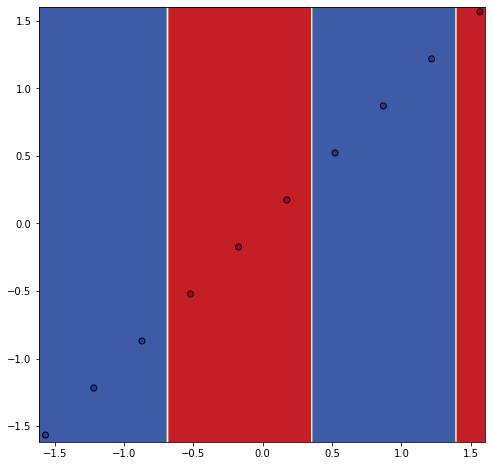

In [2]:
def g(X, val, op):
    if op == 1:
        # op = 1, sign(X > val)
        return np.sign(X - val)
    else:
        # op = -1, sign(X < val)
        return np.sign(val - X)

m = 10
n = 2

X = np.arange(m * n).reshape((m, n))
# X[3, 0] -= 20
# normalize
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y = np.array([1., 1., 1., -1., -1., -1., 1., 1., 1., -1.])
w = np.ones(m) / m

X_sorted = np.sort(X, axis=0)
all_sps = (X_sorted[:-1, :] + X_sorted[1:, :]) / 2
all_ops = np.ones((m - 1) * n).reshape((m - 1, n))
all_ers = np.ones((m - 1) * n).reshape((m - 1, n))

steps = 100
er_threhold = 1e-10
epsilon = 1e-16

# calculate all errors
for j in range(n):
    for i in range(m - 1):
        all_ers[i, j] = np.sum(w * (g(X[:, j], all_sps[i, j], all_ops[i, j]) != y))
        if all_ers[i, j] > 0.5:
            all_ops[i, j] = - all_ops[i, j]
            all_ers[i, j] = 1. - all_ers[i, j]

# choose 'm_weak_classifiers' of weak classifier
m_weak_classifiers = (m - 1) * n
a = np.zeros(m_weak_classifiers).reshape((m - 1, n))
sps = all_sps
ops = all_ops
ers = all_ers

# show all weak classifiers
print('- All the optional weak classifiers as below:')
for j in range(n):
    for i in range(m - 1):
        op = ''
        if ops[i, j] == 1:
            op = '>'
        else:
            op = '<'
        print('G%d_%d(x) = sign(x%d%s%.1f), er = %.4f' % (i, j, j, op, sps[i, j], ers[i, j]))

# run N epoches, if err < 1e-10, break
print('- Steps run:')
func_idxs = []
for step in range(steps):
    # choose best weak classifier of current step
    ers = np.ones(m_weak_classifiers).reshape((m - 1, n))
    for j in range(n):
        for i in range(m - 1):
            ers[i, j] = np.sum(w * (g(X[:, j], sps[i, j], ops[i, j]) != y))

    idx = np.argmin(ers)
    idx_m, idx_n = idx // n, idx % n
    
    # calculate parameters iteratively
    a[idx_m, idx_n] = 1 / 2 * np.log((1 - ers[idx_m, idx_n]) / np.maximum(ers[idx_m, idx_n], epsilon))
    z = np.sum(w * np.exp(- a[idx_m, idx_n] * y * g(X[:, idx_n], sps[idx_m, idx_n], ops[idx_m, idx_n])))
    w = w / z * np.exp(- a[idx_m, idx_n] * y * g(X[:, idx_n], sps[idx_m, idx_n], ops[idx_m, idx_n]))
    
    # estimate
    res = 0.
    for j in range(n):
        for i in range(m - 1):
            res += a[i, j] * g(X[:, j], sps[i, j], ops[i, j])
    er = np.sum(np.sign(res) != y)
    
    print('[Step %d] G%d_%d(x%d), a[%d, %d]=%.4f, z=%.4f, w=%s, er=%.4f' % (step, idx_m, idx_n, idx_n, idx_m, idx_n, a[idx_m, idx_n], z, w, er/m))
    
    if er < er_threhold:
        # show function
#         func_idxs = []
        for j in range(n):
            for i in range(m - 1):
                if a[i, j] != 0.:
                    func_idxs.append((i, j))
        
        func = 'G(x) = sign['
        for nrow, (i, j) in enumerate(func_idxs):
            func = '%s%.4f*G%d_%d(x%d)' % (func, a[i, j], i, j, j)
            if nrow < len(func_idxs) - 1:
                func = '%s + ' % (func)
                
        func = '%s]' % (func)
        print('- Final G(x):')
        print(func)
        break

# plot
print('- Plot:')
x_min, x_max = np.min(X, axis=0)[0] - .05, np.max(X, axis=0)[0] + .05
y_min, y_max = np.min(X, axis=0)[1] - .05, np.max(X, axis=0)[1] + .05
# print(x_min, x_max)
# print(y_min, y_max)
plot_step = .02
X_bg = [np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)]
xx, yy = np.meshgrid(X_bg[0], X_bg[1])

# z = G(x)
z = np.zeros(xx.ravel().shape)
for (i, j) in func_idxs:
    if j == 0:
        z += a[i, j] * g(xx.ravel(), sps[i, j], ops[i, j])
    else:
        z += a[i, j] * g(yy.ravel(), sps[i, j], ops[i, j])
z = np.sign(z)
z = z.reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, z, cmap=plt.cm.RdYlBu)

plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdYlBu)

plt.show()